In [3]:
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql import types as T

import json
import urllib2

#Imports to enable visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
#OTP_SERVER_URL = 'http://150.165.85.4:10402/otp/'
OTP_SERVER_URL = 'http://localhost:5601/otp/'

def rename_columns(df, list_of_tuples):
    for (old_col, new_col) in list_of_tuples:
        df = df.withColumnRenamed(old_col, new_col)
    return df

def read_hdfs_folder(sqlContext, folderpath):
    data_frame = sqlContext.read.csv(folderpath, header=True,
                                     inferSchema=True,nullValue="-")
    return data_frame

def read_buste_data_v3(sqlContext, folderpath):
    data_frame = read_hdfs_folder(sqlContext,folderpath)
    
    date = "-".join(folderpath.split("/")[-2].split("_")[:3])

    data_frame = data_frame.withColumn("date", F.date_sub(F.lit(date),1))
    #data_frame = data_frame.withColumn("date", F.unix_timestamp(F.col("date"),1),'yyyy-MM-dd'))
    
    return data_frame

def printdf(df,l=10):
    return df.limit(l).toPandas()

def get_timestamp_in_tz(unixtime_timestamp,ts_format,tz):
    return F.from_utc_timestamp(F.from_unixtime(unixtime_timestamp, ts_format),tz)

In [5]:
spark  = SparkSession.builder.getOrCreate()
spark.conf.set('spark.sql.crossJoin.enabled', 'true')

sc = spark.sparkContext
sqlContext = pyspark.SQLContext(sc)

### Reading Data

In [22]:
#base_folder_path = '/local/tarciso/masters/experiments/preliminary-exp/preliminary-exp-sample-data/buste-v3a/'
base_folder_path = '/local/tarciso/data/trips-optimality-exp/06_18-24_2017/'
date_to_be_analized = F.unix_timestamp(F.lit('2017-06-21'),'yyyy-MM-dd')
od_matrix = read_hdfs_folder(sqlContext,base_folder_path + 'filtered_od/')

In [23]:
od_matrix.printSchema()

root
 |-- route: integer (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- shapeId: integer (nullable = true)
 |-- shapeSequence: integer (nullable = true)
 |-- shapeLat: double (nullable = true)
 |-- shapeLon: double (nullable = true)
 |-- distanceTraveledShape: double (nullable = true)
 |-- busCode: string (nullable = true)
 |-- gpsPointId: string (nullable = true)
 |-- gpsLat: double (nullable = true)
 |-- gpsLon: double (nullable = true)
 |-- distanceToShapePoint: double (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- problem: string (nullable = true)
 |-- birthdate: string (nullable = true)
 |-- cardTimestamp: string (nullable = true)
 |-- lineName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- date: integer (nullable = true)
 |-- id: long (nullable = true)
 |-- o_route: integer (nullable = true)
 |-- o_bus_code: string (nullable = true)
 |-- o_date: integer (nullable = true)
 |-- o_trip

In [24]:
printdf(od_matrix.select(['date','route','o_stop_id','o_timestamp','stopPointId','timestamp','o_boarding_id']))

,date,route,o_stop_id,o_timestamp,stopPointId,timestamp,o_boarding_id
0,1497668400,393,35438,12:28:00,34221,13:20:04,17179869192
1,1497668400,655,36208,14:14:51,38509,14:14:54,1683627180038
2,1497668400,658,35536,14:28:29,38498,14:28:50,1589137899525
3,1497668400,924,36660,18:59:21,27340,19:13:40,438086664200
4,1497668400,625,36078,06:54:02,25639,07:04:25,85899345929
5,1497668400,825,34633,17:25:38,36478,17:56:45,240518168587
6,1497668400,272,30775,18:55:27,32320,20:26:10,1554778161167
7,1497668400,673,32163,19:23:06,32173,21:53:41,824633720840
8,1497668400,761,32402,09:08:55,32847,10:13:41,850403524628
9,1497668400,711,35430,17:16:39,8871,17:20:01,1262720385057


In [25]:
od_matrix.count()

24911

### Filtering Data

In [26]:
od_matrix = od_matrix.filter(od_matrix.date == date_to_be_analized)

In [27]:
printdf(od_matrix.select('date'))

,date
0,1498014000
1,1498014000
2,1498014000
3,1498014000
4,1498014000
5,1498014000
6,1498014000
7,1498014000
8,1498014000
9,1498014000


In [21]:
od_matrix.count()

3024

#### Advancing start time by two minutes to correct for any GPS precision problems when starting at a bus stop

In [29]:
extra_seconds = 120
od_matrix = od_matrix.withColumn('date_str', F.from_unixtime(F.col('date'), 'yyyy-MM-dd')) \
                        .withColumn('o_datetime', F.concat(F.col('date_str'), F.lit(' '), F.col('o_timestamp'))) \
                        .withColumn('d_datetime', F.concat(F.col('date_str'), F.lit(' '), F.col('timestamp'))) \
                        .withColumn('executed_duration', (F.unix_timestamp('d_datetime') - F.unix_timestamp('o_datetime'))/60) \
                        .withColumn('o_base_datetime', F.from_unixtime(F.unix_timestamp(F.col('o_datetime'),'yyyy-MM-dd HH:mm:ss') - extra_seconds, 'yyyy-MM-dd HH:mm:ss')) \

In [30]:
printdf(od_matrix.select(['date_str','o_timestamp','o_datetime','d_datetime','executed_duration','o_base_datetime']))

,date_str,o_timestamp,o_datetime,d_datetime,executed_duration,o_base_datetime
0,2017-06-21,14:14:14,2017-06-21 14:14:14,2017-06-21 14:28:57,14.716667,2017-06-21 14:12:14
1,2017-06-21,16:50:36,2017-06-21 16:50:36,2017-06-21 16:58:22,7.766667,2017-06-21 16:48:36
2,2017-06-21,17:55:05,2017-06-21 17:55:05,2017-06-21 19:59:51,124.766667,2017-06-21 17:53:05
3,2017-06-21,14:36:47,2017-06-21 14:36:47,2017-06-21 15:52:33,75.766667,2017-06-21 14:34:47
4,2017-06-21,18:03:13,2017-06-21 18:03:13,2017-06-21 18:37:28,34.250000,2017-06-21 18:01:13
5,2017-06-21,07:44:14,2017-06-21 07:44:14,2017-06-21 08:07:43,23.483333,2017-06-21 07:42:14
6,2017-06-21,16:33:17,2017-06-21 16:33:17,2017-06-21 18:31:37,118.333333,2017-06-21 16:31:17
7,2017-06-21,07:29:33,2017-06-21 07:29:33,2017-06-21 08:02:11,32.633333,2017-06-21 07:27:33
8,2017-06-21,08:19:52,2017-06-21 08:19:52,2017-06-21 08:30:10,10.300000,2017-06-21 08:17:52
9,2017-06-21,07:18:08,2017-06-21 07:18:08,2017-06-21 08:26:57,68.816667,2017-06-21 07:16:08


In [39]:
def get_otp_itineraries(o_lat,o_lon,d_lat,d_lon,date,time):
    otp_http_request = 'routers/ctba/plan?fromPlace={},{}&toPlace={},{}&mode=TRANSIT,WALK&date={}&time={}'
    otp_request_url = OTP_SERVER_URL + otp_http_request.format(o_lat,o_lon,d_lat,d_lon,date,time)
    #print otp_request_url
    return json.loads(urllib2.urlopen(otp_request_url).read())

In [40]:
test_itinerary = get_otp_itineraries(-25.413083,-49.229020,-25.428322,-49.266739,'05-10-2017','7:19:00')

print test_itinerary

{u'elevationMetadata': {u'geoidElevation': False, u'ellipsoidToGeoidDifference': 3.686111287840708}, u'plan': {u'date': 1494411540000, u'to': {u'lat': -25.428322, u'vertexType': u'NORMAL', u'lon': -49.266739, u'name': u'Destination', u'orig': u''}, u'itineraries': [{u'walkTime': 2, u'legs': [{u'distance': 0.151, u'from': {u'vertexType': u'NORMAL', u'name': u'Origin', u'lon': -49.22902, u'departure': 1494411566000, u'lat': -25.413083, u'orig': u''}, u'interlineWithPreviousLeg': False, u'transitLeg': False, u'realTime': False, u'route': u'', u'departureDelay': 0, u'agencyTimeZoneOffset': -10800000, u'to': {u'arrival': 1494411567000, u'vertexType': u'TRANSIT', u'name': u'Rua Fagundes Varela, 1295 - Jardim Social', u'stopSequence': 12, u'lon': -49.229029895014, u'departure': 1494411568000, u'stopId': u'1:31957', u'stopCode': u'130279', u'lat': -25.413059468751, u'stopIndex': 11}, u'rentedBike': False, u'arrivalDelay': 0, u'mode': u'WALK', u'startTime': 1494411566000, u'duration': 1.0, u'st

### New Approach

In [41]:
trips_otp_response = {}
counter = 0
for row in od_matrix.collect():
        id=long(row['o_boarding_id'])
        start_time = row['o_base_datetime'].split(' ')[1]
        trip_plan = get_otp_itineraries(row['o_shape_lat'], row['o_shape_lon'], row['shapeLat'], row['shapeLon'],row['date_str'],start_time)
        trips_otp_response[id] = trip_plan
        counter+=1

In [42]:
#max_ctr = 1
trips_plans = []

for trip in trips_otp_response.keys():
    #if max_ctr == 0:
    #    break
    if 'plan' in trips_otp_response[trip]:
        itinerary_id = 1
        for itinerary in trips_otp_response[trip]['plan']['itineraries']:
            date = trips_otp_response[trip]['plan']['date']/1000
            leg_id = 1
            for leg in itinerary['legs']:
                route = leg['route'] if leg['route'] != '' else None
                fromStopId = leg['from']['stopId'].split(':')[1] if leg['mode'] == 'BUS' else None
                toStopId = leg['to']['stopId'].split(':')[1] if leg['mode'] == 'BUS' else None
                start_time = long(leg['startTime'])/1000
                end_time = long(leg['endTime'])/1000
                duration = (end_time - start_time)/60
                trips_plans.append((date,trip,itinerary_id,leg_id,start_time,end_time,leg['mode'],route,fromStopId,toStopId, duration))
                leg_id += 1
            itinerary_id += 1
    #max_ctr -= 1

labels=['date','user_trip_id','itinerary_id','leg_id','otp_start_time','otp_end_time','mode','route','from_stop_id','to_stop_id','otp_duration_mins']
trips_plans_df = sqlContext.createDataFrame(trips_plans, labels) \
                    .withColumn('date',F.from_unixtime(F.col('date'),'yyyy-MM-dd')) \
                    .withColumn('otp_duration_mins',((F.col('otp_end_time') - F.col('otp_start_time'))/60)) \
                    .withColumn('otp_start_time',F.from_unixtime(F.col('otp_start_time'),'yyyy-MM-dd HH:mm:ss').astype('timestamp')) \
                    .withColumn('otp_end_time',F.from_unixtime(F.col('otp_end_time'),'yyyy-MM-dd HH:mm:ss').astype('timestamp')) \
                    .withColumn('route', F.col('route').astype('integer')) \
                    .withColumn('from_stop_id', F.col('from_stop_id').astype('integer')) \
                    .withColumn('to_stop_id', F.col('to_stop_id').astype('integer')) \
                    .orderBy(['date','user_trip_id','itinerary_id','otp_start_time'])

In [43]:
trips_plans_df.printSchema()

root
 |-- date: string (nullable = true)
 |-- user_trip_id: long (nullable = true)
 |-- itinerary_id: long (nullable = true)
 |-- leg_id: long (nullable = true)
 |-- otp_start_time: timestamp (nullable = true)
 |-- otp_end_time: timestamp (nullable = true)
 |-- mode: string (nullable = true)
 |-- route: integer (nullable = true)
 |-- from_stop_id: integer (nullable = true)
 |-- to_stop_id: integer (nullable = true)
 |-- otp_duration_mins: double (nullable = true)



In [45]:
total_num_trips = trips_plans_df.count()
total_num_bus_trips = trips_plans_df.filter('mode == \'BUS\'').count()
print "Total num Legs:", total_num_trips
print "Total num Bus Legs:", total_num_bus_trips, "(", 100*(total_num_bus_trips/float(total_num_trips)), "%)"

Total num Legs: 25669
Total num Bus Legs: 8519 ( 33.1878920098 %)


In [52]:
print trips_plans_df.select(['user_trip_id']).distinct().count()

3006


In [53]:
printdf(trips_plans_df,l=100)

,date,user_trip_id,itinerary_id,leg_id,otp_start_time,otp_end_time,mode,route,from_stop_id,to_stop_id,otp_duration_mins
0,2017-06-21,13,1,1,2017-06-21 06:00:15,2017-06-21 06:06:29,WALK,NaN,NaN,NaN,6.233333
1,2017-06-21,15,1,1,2017-06-21 08:58:55,2017-06-21 09:00:31,WALK,NaN,NaN,NaN,1.600000
2,2017-06-21,15,1,2,2017-06-21 09:00:32,2017-06-21 09:52:58,BUS,30.0,32513.0,32606.0,52.433333
3,2017-06-21,15,1,3,2017-06-21 09:52:59,2017-06-21 09:53:47,WALK,NaN,NaN,NaN,0.800000
4,2017-06-21,15,2,1,2017-06-21 09:42:55,2017-06-21 09:44:31,WALK,NaN,NaN,NaN,1.600000
5,2017-06-21,15,2,2,2017-06-21 09:44:32,2017-06-21 10:37:44,BUS,30.0,32513.0,32606.0,53.200000
6,2017-06-21,15,2,3,2017-06-21 10:37:45,2017-06-21 10:38:33,WALK,NaN,NaN,NaN,0.800000
7,2017-06-21,15,3,1,2017-06-21 10:06:30,2017-06-21 10:08:06,WALK,NaN,NaN,NaN,1.600000
8,2017-06-21,15,3,2,2017-06-21 10:08:07,2017-06-21 11:02:19,BUS,30.0,32513.0,32606.0,54.200000
9,2017-06-21,15,3,3,2017-06-21 11:02:20,2017-06-21 11:03:08,WALK,NaN,NaN,NaN,0.800000


In [54]:
trips_plans_df.write.csv(path=base_folder_path+'/trip_plans',header=True, mode='overwrite')

In [108]:
# simple_od_matrix = od_matrix.select(['date','route','o_stop_id','stopPointId','o_boarding_id']) \
#                         .withColumnRenamed('o_stop_id','from_stop_id') \
#                         .withColumnRenamed('stopPointId','to_stop_id')

In [109]:
# simple_od_matrix.printSchema()

In [110]:
# printdf(simple_od_matrix)

In [111]:
# labelled_trips_plans = trips_plans_df.join(simple_od_matrix, on=['date','route','from_stop_id','to_stop_id'], how='inner')

In [112]:
# printdf(labelled_trips_plans)

### Read Bus Data

In [55]:
print base_folder_path

/local/tarciso/data/trips-optimality-exp/06_18-24_2017/


In [69]:
bus_trips_data = read_buste_data_v3(sqlContext,base_folder_path + '/buste/per_day/2017_06_22_veiculos/')

In [70]:
bus_trips_data.printSchema()

root
 |-- route: integer (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- shapeId: integer (nullable = true)
 |-- shapeSequence: integer (nullable = true)
 |-- shapeLat: double (nullable = true)
 |-- shapeLon: double (nullable = true)
 |-- distanceTraveledShape: double (nullable = true)
 |-- busCode: string (nullable = true)
 |-- gpsPointId: string (nullable = true)
 |-- gpsLat: double (nullable = true)
 |-- gpsLon: double (nullable = true)
 |-- distanceToShapePoint: double (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- problem: string (nullable = true)
 |-- birthdate: string (nullable = true)
 |-- cardTimestamp: string (nullable = true)
 |-- lineName: string (nullable = true)
 |-- cardNum: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- date: date (nullable = true)



In [71]:
clean_bus_trips_data = bus_trips_data.select(["date","route","busCode","tripNum","stopPointId","timestamp"]) \
                    .na.drop(subset=["date","route","busCode","tripNum","stopPointId","timestamp"]) \
                    .dropDuplicates(['route','busCode','tripNum','stopPointId']) \
                    .withColumn('route',F.col('route').astype('float')) \
                    .withColumn('date',F.col('date').astype('string')) \
                    .withColumn('timestamp',F.from_unixtime(F.unix_timestamp(F.concat(F.col('date'),F.lit(' '),F.col('timestamp')), 'yyyy-MM-dd HH:mm:ss')))

In [72]:
clean_bus_trips_data.printSchema()

root
 |-- date: string (nullable = true)
 |-- route: float (nullable = true)
 |-- busCode: string (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- timestamp: string (nullable = true)



In [73]:
printdf(clean_bus_trips_data)

,date,route,busCode,tripNum,stopPointId,timestamp
0,2017-06-21,10.0,BB302,15,33171,2017-06-21 20:09:55
1,2017-06-21,10.0,BB303,9,33163,2017-06-21 09:34:03
2,2017-06-21,10.0,BB303,12,29104,2017-06-21 14:02:48
3,2017-06-21,10.0,BB304,1,28637,2017-06-21 06:56:25
4,2017-06-21,10.0,BB304,2,28646,2017-06-21 09:50:34
5,2017-06-21,10.0,BB310,14,33175,2017-06-21 18:55:24
6,2017-06-21,10.0,BB310,17,33150,2017-06-21 12:06:58
7,2017-06-21,10.0,BB310,19,28971,2017-06-21 22:21:09
8,2017-06-21,11.0,BB002,1,32782,2017-06-21 08:22:15
9,2017-06-21,11.0,BB002,5,30149,2017-06-21 14:39:37


### Finding Real User Trip Beginning Time

In [74]:
trips_plans_df_start = trips_plans_df.withColumn('stopPointId', F.col('from_stop_id'))
trip_plans_start = trips_plans_df_start.join(clean_bus_trips_data, ['date','route','stopPointId'], how='inner') \
                        .na.drop(subset=['timestamp']) \
                        .withColumn('timediff',F.abs(F.unix_timestamp(F.col('timestamp')) - F.unix_timestamp(F.col('otp_start_time')))) \
                        .drop('otp_duration')

In [75]:
printdf(trip_plans_start.select(['date','route','from_stop_id','tripNum','otp_start_time','timestamp','timediff']) \
                .orderBy(['date','route','from_stop_id','otp_start_time','timediff']))

,date,route,from_stop_id,tripNum,otp_start_time,timestamp,timediff
0,2017-06-21,10,26900,11,2017-06-21 11:33:01,2017-06-21 10:55:36,2245
1,2017-06-21,10,26900,17,2017-06-21 11:33:01,2017-06-21 12:12:19,2358
2,2017-06-21,10,26900,16,2017-06-21 11:33:01,2017-06-21 10:53:23,2378
3,2017-06-21,10,26900,3,2017-06-21 11:33:01,2017-06-21 12:14:14,2473
4,2017-06-21,10,26900,2,2017-06-21 11:33:01,2017-06-21 10:01:04,5517
5,2017-06-21,10,26900,10,2017-06-21 11:33:01,2017-06-21 09:45:26,6455
6,2017-06-21,10,26900,12,2017-06-21 11:33:01,2017-06-21 13:26:16,6795
7,2017-06-21,10,26900,1,2017-06-21 11:33:01,2017-06-21 08:28:24,11077
8,2017-06-21,10,26900,9,2017-06-21 11:33:01,2017-06-21 07:28:13,14688
9,2017-06-21,10,26900,15,2017-06-21 11:33:01,2017-06-21 07:20:06,15175


In [76]:
trip_plans_start.printSchema()

root
 |-- date: string (nullable = true)
 |-- route: integer (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- user_trip_id: long (nullable = true)
 |-- itinerary_id: long (nullable = true)
 |-- leg_id: long (nullable = true)
 |-- otp_start_time: timestamp (nullable = true)
 |-- otp_end_time: timestamp (nullable = true)
 |-- mode: string (nullable = true)
 |-- from_stop_id: integer (nullable = true)
 |-- to_stop_id: integer (nullable = true)
 |-- otp_duration_mins: double (nullable = true)
 |-- busCode: string (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- timediff: long (nullable = true)



In [77]:
printdf(trip_plans_start)

,date,route,stopPointId,user_trip_id,itinerary_id,leg_id,otp_start_time,otp_end_time,mode,from_stop_id,to_stop_id,otp_duration_mins,busCode,tripNum,timestamp,timediff
0,2017-06-21,21,29812,472446402602,2,2,2017-06-21 07:13:34,2017-06-21 07:50:47,BUS,29812,30666,37.216667,BB603,4,2017-06-21 08:18:11,3877
1,2017-06-21,21,29812,472446402602,2,2,2017-06-21 07:13:34,2017-06-21 07:50:47,BUS,29812,30666,37.216667,BB609,6,2017-06-21 09:30:12,8198
2,2017-06-21,21,29812,472446402602,2,2,2017-06-21 07:13:34,2017-06-21 07:50:47,BUS,29812,30666,37.216667,MB603,7,2017-06-21 08:34:59,4885
3,2017-06-21,21,29812,472446402602,2,2,2017-06-21 07:13:34,2017-06-21 07:50:47,BUS,29812,30666,37.216667,BB609,7,2017-06-21 13:02:21,20927
4,2017-06-21,21,29812,472446402602,2,2,2017-06-21 07:13:34,2017-06-21 07:50:47,BUS,29812,30666,37.216667,MB603,8,2017-06-21 09:55:38,9724
5,2017-06-21,21,29812,472446402602,2,2,2017-06-21 07:13:34,2017-06-21 07:50:47,BUS,29812,30666,37.216667,BB603,6,2017-06-21 14:04:27,24653
6,2017-06-21,21,29812,472446402602,2,2,2017-06-21 07:13:34,2017-06-21 07:50:47,BUS,29812,30666,37.216667,BB603,5,2017-06-21 11:42:40,16146
7,2017-06-21,21,29812,472446402602,2,2,2017-06-21 07:13:34,2017-06-21 07:50:47,BUS,29812,30666,37.216667,BB609,2,2017-06-21 15:06:41,28387
8,2017-06-21,21,29812,472446402602,2,2,2017-06-21 07:13:34,2017-06-21 07:50:47,BUS,29812,30666,37.216667,MB603,3,2017-06-21 13:16:55,21801
9,2017-06-21,21,29812,472446402602,2,2,2017-06-21 07:13:34,2017-06-21 07:50:47,BUS,29812,30666,37.216667,BB609,5,2017-06-21 15:09:15,28541


In [78]:
w = Window.partitionBy(['date','user_trip_id','itinerary_id','route','from_stop_id']).orderBy(['timediff'])
trip_plans_start = trip_plans_start.withColumn('rn', F.row_number().over(w)) \
                    .where(F.col('rn') == 1)

In [79]:
printdf(trip_plans_start.select('route','from_stop_id','otp_start_time','timestamp') \
           .orderBy(['route','from_stop_id','otp_start_time']))

,route,from_stop_id,otp_start_time,timestamp
0,10,26900,2017-06-21 11:33:01,2017-06-21 10:55:36
1,10,28646,2017-06-21 17:43:16,2017-06-21 17:23:22
2,10,28646,2017-06-21 18:02:02,2017-06-21 18:04:39
3,10,28971,2017-06-21 15:35:12,2017-06-21 15:31:56
4,10,28971,2017-06-21 15:53:29,2017-06-21 16:13:11
5,10,28971,2017-06-21 16:12:51,2017-06-21 16:13:11
6,10,30150,2017-06-21 08:47:19,2017-06-21 08:32:41
7,10,31747,2017-06-21 12:12:36,2017-06-21 11:44:36
8,10,31920,2017-06-21 08:46:55,2017-06-21 08:25:16
9,10,31920,2017-06-21 09:04:55,2017-06-21 09:41:23


In [80]:
trip_plans_start = trip_plans_start \
        .select(['date','user_trip_id','itinerary_id','leg_id','route','busCode','tripNum','from_stop_id','otp_start_time','timestamp','to_stop_id','otp_end_time']) \
        .withColumnRenamed('timestamp','from_timestamp')
printdf(trip_plans_start)

,date,user_trip_id,itinerary_id,leg_id,route,busCode,tripNum,from_stop_id,otp_start_time,from_timestamp,to_stop_id,otp_end_time
0,2017-06-21,15,3,2,30,BB611,3,32513,2017-06-21 10:08:07,2017-06-21 09:49:27,32606,2017-06-21 11:02:19
1,2017-06-21,8589934759,1,2,380,LC302,4,26332,2017-06-21 14:52:35,2017-06-21 15:14:39,29889,2017-06-21 14:56:56
2,2017-06-21,85899345990,3,2,175,BC189,9,26676,2017-06-21 14:29:47,2017-06-21 14:28:14,28632,2017-06-21 14:35:12
3,2017-06-21,103079215210,1,2,20,BB615,6,32720,2017-06-21 16:54:50,2017-06-21 16:55:15,28132,2017-06-21 17:25:00
4,2017-06-21,163208757429,3,2,972,MC301,21,33374,2017-06-21 10:38:15,2017-06-21 10:37:56,33717,2017-06-21 10:56:41
5,2017-06-21,171798691925,3,2,972,MC307,17,26638,2017-06-21 18:56:23,2017-06-21 18:58:04,32796,2017-06-21 19:01:54
6,2017-06-21,180388626493,3,2,674,LC012,14,31730,2017-06-21 15:39:34,2017-06-21 15:40:17,32904,2017-06-21 15:59:38
7,2017-06-21,317827579999,1,2,40,MB301,1,34117,2017-06-21 05:59:56,2017-06-21 05:58:48,34134,2017-06-21 06:04:04
8,2017-06-21,352187318292,3,2,166,BC011,2,26754,2017-06-21 08:35:34,2017-06-21 08:21:11,28430,2017-06-21 08:55:00
9,2017-06-21,352187318388,1,2,168,BC005,18,32794,2017-06-21 08:28:04,2017-06-21 08:27:11,32750,2017-06-21 08:35:39


In [81]:
total_trips_start = trip_plans_start.count()

print "Total Num Bus Legs Start Identified in Data:", total_trips_start, "(", 100*(total_trips_start/float(total_num_bus_trips)), "%)"

trip_plans_start.printSchema()

Total Num Bus Legs Start Identified in Data: 7635 ( 89.6231952107 %)
root
 |-- date: string (nullable = true)
 |-- user_trip_id: long (nullable = true)
 |-- itinerary_id: long (nullable = true)
 |-- leg_id: long (nullable = true)
 |-- route: integer (nullable = true)
 |-- busCode: string (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- from_stop_id: integer (nullable = true)
 |-- otp_start_time: timestamp (nullable = true)
 |-- from_timestamp: string (nullable = true)
 |-- to_stop_id: integer (nullable = true)
 |-- otp_end_time: timestamp (nullable = true)



### Finding Real User Trip End Time

In [84]:
bus_trips_data2 = read_buste_data_v3(sqlContext,base_folder_path + '/buste/per_day/2017_06_22_veiculos/')

In [85]:
clean_bus_trips_data2 = bus_trips_data2.select(["date","route","busCode","tripNum","stopPointId","timestamp"]) \
                    .na.drop(subset=["date","route","busCode","tripNum","stopPointId","timestamp"]) \
                    .dropDuplicates(['route','busCode','tripNum','stopPointId']) \
                    .withColumn('route',F.col('route').astype('integer')) \
                    .withColumn('date',F.col('date').astype('string')) \
                    .withColumn('timestamp',F.from_unixtime(F.unix_timestamp(F.concat(F.col('date'),F.lit(' '),F.col('timestamp')), 'yyyy-MM-dd HH:mm:ss')))

In [86]:
clean_bus_trips_data2.printSchema()

root
 |-- date: string (nullable = true)
 |-- route: integer (nullable = true)
 |-- busCode: string (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- stopPointId: integer (nullable = true)
 |-- timestamp: string (nullable = true)



In [87]:
trip_plans_start.printSchema()

root
 |-- date: string (nullable = true)
 |-- user_trip_id: long (nullable = true)
 |-- itinerary_id: long (nullable = true)
 |-- leg_id: long (nullable = true)
 |-- route: integer (nullable = true)
 |-- busCode: string (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- from_stop_id: integer (nullable = true)
 |-- otp_start_time: timestamp (nullable = true)
 |-- from_timestamp: string (nullable = true)
 |-- to_stop_id: integer (nullable = true)
 |-- otp_end_time: timestamp (nullable = true)



In [88]:
trip_plans_df_end = trip_plans_start.withColumnRenamed('to_stop_id','stopPointId')
trip_plans_start_end = trip_plans_df_end.join(clean_bus_trips_data2, ['date','route','busCode','tripNum','stopPointId'], how='inner') \
                        .na.drop(subset=['timestamp']) \
                        .withColumn('timediff',F.abs(F.unix_timestamp(F.col('timestamp')) - F.unix_timestamp(F.col('otp_end_time'))))

In [89]:
trip_plans_start_end = trip_plans_start_end.withColumnRenamed('timestamp', 'to_timestamp') \
                .withColumnRenamed('stopPointId','to_stop_id') \
                .orderBy(['date','route','stopPointId','timediff'])
                
printdf(trip_plans_start_end.select(['date','route','to_stop_id','tripNum','to_timestamp','otp_end_time','timediff']))

,date,route,to_stop_id,tripNum,to_timestamp,otp_end_time,timediff
0,2017-06-21,10,26455,3,2017-06-21 12:12:58,2017-06-21 14:00:06,6428
1,2017-06-21,10,26900,17,2017-06-21 12:12:19,2017-06-21 12:15:09,170
2,2017-06-21,10,26900,7,2017-06-21 20:00:39,2017-06-21 19:57:04,215
3,2017-06-21,10,26900,15,2017-06-21 07:20:06,2017-06-21 07:03:17,1009
4,2017-06-21,10,26900,10,2017-06-21 09:45:26,2017-06-21 10:03:01,1055
5,2017-06-21,10,26900,17,2017-06-21 12:12:19,2017-06-21 12:30:01,1062
6,2017-06-21,10,26900,7,2017-06-21 20:00:39,2017-06-21 19:34:06,1593
7,2017-06-21,10,26900,17,2017-06-21 12:12:19,2017-06-21 12:46:45,2066
8,2017-06-21,10,26900,15,2017-06-21 07:20:06,2017-06-21 06:30:20,2986
9,2017-06-21,10,26900,3,2017-06-21 12:14:14,2017-06-21 14:39:45,8731


In [90]:
trip_plans_start_end.printSchema()

root
 |-- date: string (nullable = true)
 |-- route: integer (nullable = true)
 |-- busCode: string (nullable = true)
 |-- tripNum: integer (nullable = true)
 |-- to_stop_id: integer (nullable = true)
 |-- user_trip_id: long (nullable = true)
 |-- itinerary_id: long (nullable = true)
 |-- leg_id: long (nullable = true)
 |-- from_stop_id: integer (nullable = true)
 |-- otp_start_time: timestamp (nullable = true)
 |-- from_timestamp: string (nullable = true)
 |-- otp_end_time: timestamp (nullable = true)
 |-- to_timestamp: string (nullable = true)
 |-- timediff: long (nullable = true)



In [91]:
trips_actual_time = trip_plans_start_end.select(['date','user_trip_id','itinerary_id','leg_id','route','busCode','tripNum','from_stop_id','from_timestamp','to_stop_id','to_timestamp']) \
                        .withColumn('actual_duration_mins', (F.unix_timestamp(F.col('to_timestamp')) - F.unix_timestamp(F.col('from_timestamp')))/60) \
                        .orderBy(['date','user_trip_id','itinerary_id','leg_id'])

In [92]:
total_trips_found = trips_actual_time.count()
print "Total Num Trips Identified in Data:", total_trips_found, "(", 100*(total_trips_found/float(total_num_bus_trips)), "%)"

printdf(trips_actual_time)

Total Num Trips Identified in Data: 6520 ( 76.5348045545 %)


,date,user_trip_id,itinerary_id,leg_id,route,busCode,tripNum,from_stop_id,from_timestamp,to_stop_id,to_timestamp,actual_duration_mins
0,2017-06-21,15,2,2,30,BB611,4,32513,2017-06-21 09:44:06,32606,2017-06-21 13:42:49,238.716667
1,2017-06-21,17,1,2,170,BC303,2,26769,2017-06-21 07:27:30,26550,2017-06-21 07:28:36,1.100000
2,2017-06-21,17,3,2,171,BC007,5,26769,2017-06-21 07:31:58,26550,2017-06-21 07:34:21,2.383333
3,2017-06-21,39,2,2,169,BC008,30,27463,2017-06-21 20:54:29,775,2017-06-21 20:54:56,0.450000
4,2017-06-21,39,3,2,169,BC008,30,27463,2017-06-21 20:54:29,775,2017-06-21 20:54:56,0.450000
5,2017-06-21,41,1,2,860,LC027,4,34143,2017-06-21 08:06:38,29924,2017-06-21 07:18:38,-48.000000
6,2017-06-21,41,3,2,861,LC850,13,40262,2017-06-21 08:30:52,29924,2017-06-21 09:00:40,29.800000
7,2017-06-21,60,1,2,860,LC027,4,34143,2017-06-21 08:06:38,33858,2017-06-21 07:15:46,-50.866667
8,2017-06-21,60,3,2,861,LC850,13,40262,2017-06-21 08:30:52,33858,2017-06-21 08:57:28,26.600000
9,2017-06-21,79,2,2,464,MN609,7,31961,2017-06-21 16:26:09,31935,2017-06-21 18:28:58,122.816667


In [93]:
negative_duration_trips = trips_actual_time.filter(trips_actual_time.actual_duration_mins <= 0)

total_trips_negative_duration = negative_duration_trips.count()
print "Total Num Trips With Negative Duration Identified in Data:", total_trips_negative_duration, "(", 100*(total_trips_negative_duration/float(total_num_bus_trips)), "%)"

printdf(negative_duration_trips, l=50)

Total Num Trips With Negative Duration Identified in Data: 1284 ( 15.0721915718 %)


,date,user_trip_id,itinerary_id,leg_id,route,busCode,tripNum,from_stop_id,from_timestamp,to_stop_id,to_timestamp,actual_duration_mins
0,2017-06-21,41,1,2,860,LC027,4,34143,2017-06-21 08:06:38,29924,2017-06-21 07:18:38,-48.000000
1,2017-06-21,60,1,2,860,LC027,4,34143,2017-06-21 08:06:38,33858,2017-06-21 07:15:46,-50.866667
2,2017-06-21,102,3,2,30,BB611,4,32513,2017-06-21 09:44:06,32540,2017-06-21 08:44:15,-59.850000
3,2017-06-21,107,1,2,182,BC188,2,28813,2017-06-21 07:44:42,28946,2017-06-21 07:36:51,-7.850000
4,2017-06-21,123,2,2,170,BC598,17,27821,2017-06-21 12:42:19,38818,2017-06-21 11:53:08,-49.183333
5,2017-06-21,123,3,2,170,BC598,17,27821,2017-06-21 12:42:19,38818,2017-06-21 11:53:08,-49.183333
6,2017-06-21,143,1,2,703,JC307,19,31642,2017-06-21 15:16:00,35232,2017-06-21 15:13:42,-2.300000
7,2017-06-21,8589934609,3,2,170,BC186,35,36673,2017-06-21 18:39:59,36674,2017-06-21 18:39:04,-0.916667
8,2017-06-21,8589934649,2,2,274,BC905,16,31108,2017-06-21 16:25:54,28925,2017-06-21 06:44:24,-581.500000
9,2017-06-21,8589934655,1,2,972,MC077,7,32362,2017-06-21 14:53:42,29599,2017-06-21 14:52:09,-1.550000


In [94]:
trips_actual_time_filtered = trips_actual_time.filter(trips_actual_time.actual_duration_mins > 0)

In [95]:
total_trips_clean = trips_actual_time_filtered.count()
print "Total Num Clean Trips Identified in Data:", total_trips_clean, "(", 100*(total_trips_clean/float(total_num_bus_trips)), "%)"

Total Num Clean Trips Identified in Data: 5236 ( 61.4626129827 %)


### Joining Walk and Bus legs into a single Dataframe

In [96]:
printdf(trips_plans_df,l=20)

,date,user_trip_id,itinerary_id,leg_id,otp_start_time,otp_end_time,mode,route,from_stop_id,to_stop_id,otp_duration_mins
0,2017-06-21,13,1,1,2017-06-21 06:00:15,2017-06-21 06:06:29,WALK,NaN,NaN,NaN,6.233333
1,2017-06-21,15,1,1,2017-06-21 08:58:55,2017-06-21 09:00:31,WALK,NaN,NaN,NaN,1.600000
2,2017-06-21,15,1,2,2017-06-21 09:00:32,2017-06-21 09:52:58,BUS,30.0,32513.0,32606.0,52.433333
3,2017-06-21,15,1,3,2017-06-21 09:52:59,2017-06-21 09:53:47,WALK,NaN,NaN,NaN,0.800000
4,2017-06-21,15,2,1,2017-06-21 09:42:55,2017-06-21 09:44:31,WALK,NaN,NaN,NaN,1.600000
5,2017-06-21,15,2,2,2017-06-21 09:44:32,2017-06-21 10:37:44,BUS,30.0,32513.0,32606.0,53.200000
6,2017-06-21,15,2,3,2017-06-21 10:37:45,2017-06-21 10:38:33,WALK,NaN,NaN,NaN,0.800000
7,2017-06-21,15,3,1,2017-06-21 10:06:30,2017-06-21 10:08:06,WALK,NaN,NaN,NaN,1.600000
8,2017-06-21,15,3,2,2017-06-21 10:08:07,2017-06-21 11:02:19,BUS,30.0,32513.0,32606.0,54.200000
9,2017-06-21,15,3,3,2017-06-21 11:02:20,2017-06-21 11:03:08,WALK,NaN,NaN,NaN,0.800000


In [97]:
trips_actual_itineraries = trips_plans_df.join(trips_actual_time_filtered, on=['date','user_trip_id','itinerary_id','leg_id', 'route', 'from_stop_id','to_stop_id'], how='left_outer')

In [98]:
printdf(trips_actual_itineraries.filter('mode == \'BUS\'').orderBy(['itinerary_id','leg_id','otp_start_time']), l=20)

,date,user_trip_id,itinerary_id,leg_id,route,from_stop_id,to_stop_id,otp_start_time,otp_end_time,mode,otp_duration_mins,busCode,tripNum,from_timestamp,to_timestamp,actual_duration_mins
0,2017-06-21,807453851689,1,1,760,26142,32829,2017-06-21 05:57:00,2017-06-21 06:10:46,BUS,13.766667,JC852,16.0,2017-06-21 05:51:30,2017-06-21 06:06:58,15.466667
1,2017-06-21,1425929142312,1,1,182,31854,26353,2017-06-21 06:02:51,2017-06-21 06:29:00,BUS,26.150000,BC310,8.0,2017-06-21 06:01:59,2017-06-21 06:30:09,28.166667
2,2017-06-21,1056561954870,1,1,182,31854,26353,2017-06-21 06:02:51,2017-06-21 06:29:00,BUS,26.150000,BC310,8.0,2017-06-21 06:01:59,2017-06-21 06:30:09,28.166667
3,2017-06-21,652835029031,1,1,182,31854,28615,2017-06-21 06:02:51,2017-06-21 06:27:08,BUS,24.283333,BC310,8.0,2017-06-21 06:01:59,2017-06-21 06:26:12,24.216667
4,2017-06-21,223338299506,1,1,30,30459,32550,2017-06-21 06:38:00,2017-06-21 07:20:38,BUS,42.633333,None,NaN,None,None,NaN
5,2017-06-21,403726925827,1,1,205,30615,30601,2017-06-21 06:46:00,2017-06-21 06:56:43,BUS,10.716667,BC311,1.0,2017-06-21 06:45:32,2017-06-21 06:54:20,8.800000
6,2017-06-21,1357209665584,1,1,876,10320,33768,2017-06-21 07:05:00,2017-06-21 07:07:39,BUS,2.650000,BC300,17.0,2017-06-21 06:59:28,2017-06-21 22:36:26,936.966667
7,2017-06-21,257698037903,1,1,814,30261,30283,2017-06-21 07:08:20,2017-06-21 07:11:43,BUS,3.383333,LA851,11.0,2017-06-21 07:05:04,2017-06-21 07:08:52,3.800000
8,2017-06-21,910533066779,1,1,166,662,26769,2017-06-21 07:10:00,2017-06-21 07:35:50,BUS,25.833333,BC016,15.0,2017-06-21 07:07:43,2017-06-21 07:30:52,23.150000
9,2017-06-21,755914244130,1,1,166,662,28430,2017-06-21 07:10:00,2017-06-21 07:40:00,BUS,30.000000,BC016,15.0,2017-06-21 07:07:43,2017-06-21 07:40:38,32.916667


In [99]:
trips_actual_itineraries = trips_actual_itineraries.withColumn('considered_duration_mins', F.when(F.col('mode') == F.lit('BUS'), F.col('actual_duration_mins')).otherwise(F.col('otp_duration_mins')))

In [100]:
total_num_legs = trips_actual_itineraries.count()

print "Total Number of Legs:", total_num_legs

printdf(trips_actual_itineraries, l=20)

Total Number of Legs: 25669


,date,user_trip_id,itinerary_id,leg_id,route,from_stop_id,to_stop_id,otp_start_time,otp_end_time,mode,otp_duration_mins,busCode,tripNum,from_timestamp,to_timestamp,actual_duration_mins,considered_duration_mins
0,2017-06-21,8589934595,2,3,NaN,NaN,NaN,2017-06-21 12:28:01,2017-06-21 12:28:04,WALK,0.050000,None,NaN,None,None,NaN,0.050000
1,2017-06-21,8589934595,3,2,285.0,29227.0,28924.0,2017-06-21 12:27:33,2017-06-21 12:30:20,BUS,2.783333,None,NaN,None,None,NaN,NaN
2,2017-06-21,8589934679,1,1,NaN,NaN,NaN,2017-06-21 07:10:36,2017-06-21 07:10:38,WALK,0.033333,None,NaN,None,None,NaN,0.033333
3,2017-06-21,8589934757,1,2,372.0,30194.0,30186.0,2017-06-21 12:17:43,2017-06-21 12:23:52,BUS,6.150000,None,NaN,None,None,NaN,NaN
4,2017-06-21,34359738400,3,3,NaN,NaN,NaN,2017-06-21 07:32:49,2017-06-21 07:35:36,WALK,2.783333,None,NaN,None,None,NaN,2.783333
5,2017-06-21,103079215209,2,1,NaN,NaN,NaN,2017-06-21 08:40:39,2017-06-21 08:47:45,WALK,7.100000,None,NaN,None,None,NaN,7.100000
6,2017-06-21,111669149722,2,3,10.0,33156.0,33158.0,2017-06-21 08:56:00,2017-06-21 09:02:32,BUS,6.533333,None,NaN,None,None,NaN,NaN
7,2017-06-21,111669149831,3,3,NaN,NaN,NaN,2017-06-21 17:20:01,2017-06-21 17:20:02,WALK,0.016667,None,NaN,None,None,NaN,0.016667
8,2017-06-21,120259084407,2,2,370.0,30226.0,30181.0,2017-06-21 17:16:39,2017-06-21 17:48:43,BUS,32.066667,BC032,23.0,2017-06-21 16:47:58,2017-06-21 17:20:19,32.350000,32.350000
9,2017-06-21,146028888243,3,3,NaN,NaN,NaN,2017-06-21 12:43:01,2017-06-21 12:43:15,WALK,0.233333,None,NaN,None,None,NaN,0.233333


In [101]:
legs_not_fully_identified = trips_actual_itineraries.filter((trips_actual_itineraries.mode == 'BUS') & (trips_actual_itineraries.busCode.isNull()))

In [102]:
total_trips_not_found = legs_not_fully_identified.count()
print "Total Num Trips Not Identified in Data:", total_trips_not_found, "(", 100*(total_trips_not_found/float(total_num_bus_trips)), "%)"

printdf(legs_not_fully_identified, l=20)

Total Num Trips Not Identified in Data: 3283 ( 38.5373870173 %)


,date,user_trip_id,itinerary_id,leg_id,route,from_stop_id,to_stop_id,otp_start_time,otp_end_time,mode,otp_duration_mins,busCode,tripNum,from_timestamp,to_timestamp,actual_duration_mins,considered_duration_mins
0,2017-06-21,8589934595,3,2,285,29227,28924,2017-06-21 12:27:33,2017-06-21 12:30:20,BUS,2.783333,None,None,None,None,None,None
1,2017-06-21,8589934757,1,2,372,30194,30186,2017-06-21 12:17:43,2017-06-21 12:23:52,BUS,6.150000,None,None,None,None,None,None
2,2017-06-21,111669149722,2,3,10,33156,33158,2017-06-21 08:56:00,2017-06-21 09:02:32,BUS,6.533333,None,None,None,None,None,None
3,2017-06-21,438086664307,2,2,461,30216,30223,2017-06-21 12:13:16,2017-06-21 12:15:04,BUS,1.800000,None,None,None,None,None,None
4,2017-06-21,455266533527,1,2,180,28615,28946,2017-06-21 09:45:33,2017-06-21 09:47:39,BUS,2.100000,None,None,None,None,None,None
5,2017-06-21,584115552376,1,2,171,36662,28326,2017-06-21 18:58:28,2017-06-21 19:15:00,BUS,16.533333,None,None,None,None,None,None
6,2017-06-21,712964571182,3,2,374,31933,31995,2017-06-21 12:00:32,2017-06-21 12:19:18,BUS,18.766667,None,None,None,None,None,None
7,2017-06-21,764504178840,3,2,870,34406,30261,2017-06-21 13:43:19,2017-06-21 14:00:47,BUS,17.466667,None,None,None,None,None,None
8,2017-06-21,824633720850,2,2,865,26329,28604,2017-06-21 14:14:00,2017-06-21 14:16:11,BUS,2.183333,None,None,None,None,None,None
9,2017-06-21,893353197639,3,2,703,35235,33480,2017-06-21 21:51:37,2017-06-21 22:05:39,BUS,14.033333,None,None,None,None,None,None


In [103]:
itineraries_not_fully_identified = legs_not_fully_identified.select(['date','user_trip_id','itinerary_id']).distinct()

In [104]:
num_itineraries_not_fully_identified = itineraries_not_fully_identified.count()
total_num_itineraries = trips_actual_itineraries.select('itinerary_id').count()

print "Number of Itineraries not fully identified:", num_itineraries_not_fully_identified, "(", 100*(num_itineraries_not_fully_identified/float(total_num_itineraries)), "%)"

printdf(itineraries_not_fully_identified)

Number of Itineraries not fully identified: 3201 ( 12.4702949083 %)


,date,user_trip_id,itinerary_id
0,2017-06-21,670014898177,1
1,2017-06-21,807453851661,2
2,2017-06-21,1047972020302,2
3,2017-06-21,60129542195,1
4,2017-06-21,171798691880,3
5,2017-06-21,171798691880,2
6,2017-06-21,1460288880684,3
7,2017-06-21,171798691854,3
8,2017-06-21,1271310319632,1
9,2017-06-21,1022202216566,2


In [105]:
itineraries_fully_identified = trips_actual_itineraries.select(['date','user_trip_id','itinerary_id']).subtract(itineraries_not_fully_identified)

In [106]:
trips_actual_itineraries_filtered = trips_actual_itineraries.join(itineraries_fully_identified, on=['date','user_trip_id','itinerary_id'], how='inner')

In [107]:
total_num_filtered_legs = trips_actual_itineraries_filtered.count()

print "Total Number of Filtered Legs (whose itineraries were fully identified):", total_num_filtered_legs, "(", 100*(total_num_filtered_legs/float(total_num_legs)), "%)"

printdf(trips_actual_itineraries_filtered)

Total Number of Filtered Legs (whose itineraries were fully identified): 15731 ( 61.2840391133 %)


,date,user_trip_id,itinerary_id,leg_id,route,from_stop_id,to_stop_id,otp_start_time,otp_end_time,mode,otp_duration_mins,busCode,tripNum,from_timestamp,to_timestamp,actual_duration_mins,considered_duration_mins
0,2017-06-21,39,2,1,NaN,NaN,NaN,2017-06-21 20:33:40,2017-06-21 20:33:52,WALK,0.200000,None,NaN,None,None,NaN,0.200000
1,2017-06-21,39,2,2,169.0,27463.0,775.0,2017-06-21 20:33:53,2017-06-21 20:35:00,BUS,1.116667,BC008,30.0,2017-06-21 20:54:29,2017-06-21 20:54:56,0.450000,0.450000
2,2017-06-21,39,2,3,NaN,NaN,NaN,2017-06-21 20:35:01,2017-06-21 20:35:02,WALK,0.016667,None,NaN,None,None,NaN,0.016667
3,2017-06-21,120259084382,2,1,NaN,NaN,NaN,2017-06-21 14:29:49,2017-06-21 14:29:55,WALK,0.100000,None,NaN,None,None,NaN,0.100000
4,2017-06-21,120259084382,2,3,NaN,NaN,NaN,2017-06-21 14:34:04,2017-06-21 14:34:13,WALK,0.150000,None,NaN,None,None,NaN,0.150000
5,2017-06-21,120259084382,2,2,168.0,26880.0,26885.0,2017-06-21 14:29:56,2017-06-21 14:34:03,BUS,4.116667,BC005,6.0,2017-06-21 14:19:26,2017-06-21 14:28:17,8.850000,8.850000
6,2017-06-21,128849018957,2,1,NaN,NaN,NaN,2017-06-21 06:37:58,2017-06-21 06:46:27,WALK,8.483333,None,NaN,None,None,NaN,8.483333
7,2017-06-21,171798691877,1,1,NaN,NaN,NaN,2017-06-21 15:04:07,2017-06-21 15:11:13,WALK,7.100000,None,NaN,None,None,NaN,7.100000
8,2017-06-21,171798691877,1,2,167.0,37545.0,26718.0,2017-06-21 15:11:14,2017-06-21 15:26:58,BUS,15.733333,BC934,6.0,2017-06-21 17:13:18,2017-06-21 17:27:41,14.383333,14.383333
9,2017-06-21,171798691877,1,3,NaN,NaN,NaN,2017-06-21 15:26:59,2017-06-21 15:30:08,WALK,3.150000,None,NaN,None,None,NaN,3.150000


### Aggregating Itineraries Legs to compute metrics on them

In [108]:
trips_itineraries_duration = trips_actual_itineraries_filtered.groupBy(['date', 'user_trip_id', 'itinerary_id']) \
                                .agg(F.sum('considered_duration_mins').alias('duration')) \
                                .orderBy(['date','user_trip_id','itinerary_id'])

In [109]:
printdf(trips_itineraries_duration)

,date,user_trip_id,itinerary_id,duration
0,2017-06-21,13,1,6.233333
1,2017-06-21,15,2,241.116667
2,2017-06-21,17,1,1.833333
3,2017-06-21,17,2,5.283333
4,2017-06-21,17,3,3.116667
5,2017-06-21,39,1,3.166667
6,2017-06-21,39,2,0.666667
7,2017-06-21,39,3,0.666667
8,2017-06-21,41,3,32.350000
9,2017-06-21,60,3,27.600000


In [112]:
executed_trips_duration = od_matrix.withColumnRenamed('o_boarding_id','user_trip_id') \
                            .withColumn('itinerary_id', F.lit(0)) \
                            .withColumnRenamed('executed_duration','duration') \
                            .select(['date','user_trip_id','itinerary_id','duration'])                            

In [113]:
printdf(executed_trips_duration)

,date,user_trip_id,itinerary_id,duration
0,1498014000,919123001463,0,14.716667
1,1498014000,601295421490,0,7.766667
2,1498014000,1297080123421,0,124.766667
3,1498014000,936302870556,0,75.766667
4,1498014000,1623497638005,0,34.250000
5,1498014000,678604832933,0,23.483333
6,1498014000,1606317768800,0,118.333333
7,1498014000,118,0,32.633333
8,1498014000,721554505732,0,10.300000
9,1498014000,214748364832,0,68.816667


In [114]:
trips_itineraries_possibilities = trips_itineraries_duration.union(executed_trips_duration)

In [115]:
itineraries_window = Window.partitionBy(['date','user_trip_id']).orderBy(['duration'])
itineraries_ranking_duration = trips_itineraries_possibilities.withColumn('rank', F.row_number().over(itineraries_window))

In [116]:
printdf(itineraries_ranking_duration)

,date,user_trip_id,itinerary_id,duration,rank
0,1498014000,300647710854,0,420.600000,1
1,1498014000,403726925902,0,5.050000,1
2,1498014000,558345748634,0,39.700000,1
3,1498014000,609885356099,0,7.600000,1
4,1498014000,618475290740,0,215.166667,1
5,1498014000,661424963590,0,21.600000,1
6,1498014000,936302870623,0,27.050000,1
7,1498014000,1219770712095,0,22.316667,1
8,1498014000,1279900254276,0,20.066667,1
9,1498014000,1649267441748,0,147.833333,1


In [117]:
best_itineraries_duration = itineraries_ranking_duration.filter(itineraries_ranking_duration.rank == 1) \
                                .drop('rank')

In [118]:
printdf(best_itineraries_duration)

,date,user_trip_id,itinerary_id,duration
0,1498014000,300647710854,0,420.600000
1,1498014000,403726925902,0,5.050000
2,1498014000,558345748634,0,39.700000
3,1498014000,609885356099,0,7.600000
4,1498014000,618475290740,0,215.166667
5,1498014000,661424963590,0,21.600000
6,1498014000,936302870623,0,27.050000
7,1498014000,1219770712095,0,22.316667
8,1498014000,1279900254276,0,20.066667
9,1498014000,1649267441748,0,147.833333


In [119]:
executed_trips_with_time = od_matrix.withColumnRenamed('o_boarding_id','user_trip_id') \
                            .select(['date','user_trip_id','o_datetime','executed_duration'])                            

In [120]:
printdf(executed_trips_duration)

,date,user_trip_id,itinerary_id,duration
0,1498014000,919123001463,0,14.716667
1,1498014000,601295421490,0,7.766667
2,1498014000,1297080123421,0,124.766667
3,1498014000,936302870556,0,75.766667
4,1498014000,1623497638005,0,34.250000
5,1498014000,678604832933,0,23.483333
6,1498014000,1606317768800,0,118.333333
7,1498014000,118,0,32.633333
8,1498014000,721554505732,0,10.300000
9,1498014000,214748364832,0,68.816667


In [121]:
duration_improvement_capacity = best_itineraries_duration.join(executed_trips_with_time, on=['date','user_trip_id']) \
                                    .withColumn('imp_capacity', F.col('executed_duration') - F.col('duration'))

In [122]:
printdf(duration_improvement_capacity)

,date,user_trip_id,itinerary_id,duration,o_datetime,executed_duration,imp_capacity
0,1498014000,300647710854,0,420.600000,2017-06-21 12:37:31,420.600000,0.0
1,1498014000,403726925902,0,5.050000,2017-06-21 21:44:58,5.050000,0.0
2,1498014000,558345748634,0,39.700000,2017-06-21 07:34:55,39.700000,0.0
3,1498014000,609885356099,0,7.600000,2017-06-21 17:09:04,7.600000,0.0
4,1498014000,618475290740,0,215.166667,2017-06-21 14:01:40,215.166667,0.0
5,1498014000,661424963590,0,21.600000,2017-06-21 06:51:14,21.600000,0.0
6,1498014000,936302870623,0,27.050000,2017-06-21 19:02:29,27.050000,0.0
7,1498014000,1219770712095,0,22.316667,2017-06-21 16:55:41,22.316667,0.0
8,1498014000,1279900254276,0,20.066667,2017-06-21 13:21:14,20.066667,0.0
9,1498014000,1649267441748,0,147.833333,2017-06-21 05:07:55,147.833333,0.0


In [123]:
printdf(duration_improvement_capacity.select(['duration','executed_duration','imp_capacity']).describe())

,summary,duration,executed_duration,imp_capacity
0,count,3024,3024,3024
1,mean,109.80017636684302,109.80017636684302,0.0
2,stddev,187.46212271651467,187.46212271651467,0.0
3,min,0.03333333333333333,0.03333333333333333,0.0
4,max,1079.75,1079.75,0.0


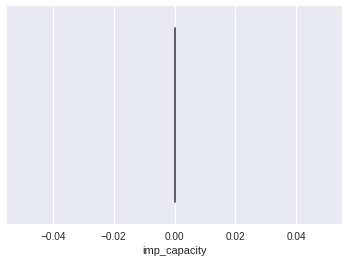

In [124]:
sns.violinplot(x=duration_improvement_capacity.toPandas()["imp_capacity"])

In [125]:
duration_improvement_capacity.write.csv(path=base_folder_path+'/duration_improvement_capacity',header=True, mode='overwrite')

In [126]:
trips_actual_itineraries_filtered.write.csv(path=base_folder_path+'/trips_actual_itineraries',header=True, mode='overwrite')